In [15]:
from tensorflow import keras
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [16]:
train_data.shape

(404, 13)

In [17]:
test_data.shape

(102, 13)

In [18]:
'''
404 training samples and 102 test samples, each with 13 numerical features, 
such as per capita crime rate, average number of rooms per dwelling, 
accessibility to highways, and so on.
'''

'\n404 training samples and 102 test samples, each with 13 numerical features, \nsuch as per capita crime rate, average number of rooms per dwelling, \naccessibility to highways, and so on.\n'

In [19]:
'''
The targets are the median values of owner-occupied homes, in thousands of dollars.

The prices are typically between 10 and 50,000 dollars. 
If that sounds cheap, remember that this was the mid-1970s, 
and these prices haven't been adjusted for inflation.
'''

"\nThe targets are the median values of owner-occupied homes, in thousands of dollars.\n\nThe prices are typically between 10 and 50,000 dollars. \nIf that sounds cheap, remember that this was the mid-1970s, \nand these prices haven't been adjusted for inflation.\n"

In [20]:
'''Normalizing the data'''

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [21]:
'''
Note that the quantities used for normalizing the test data are computed using 
the training data. You should never use any quantity computed on the test data in your 
workflow, even for something as simple as data normalization.
'''

'\nNote that the quantities used for normalizing the test data are computed using \nthe training data. You should never use any quantity computed on the test data in your \nworkflow, even for something as simple as data normalization.\n'

In [22]:
'''Model definition'''
from tensorflow.keras import layers

#using a function since we need to use the same model multiple times
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

The model ends with a single unit and no activation (*it will be a linear layer*). This is a typical setup for scalar regression which is a regression where you are trying to predict a single continuous value. Applying an activation function would constrain the range the output can take. For example, if you apply a `sigmoid` activation function to the last layer, the model could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the model is free to learn to predict values in any range.

Note that we compile the model with the `mse` loss function, `mean squared error`, the square of the difference between the predictions and the targets. This is a widely used loss function for regression problems.

We are also monitoring a new metric during training, the `mean absolute error (MAE)`. It is the
absolute value of the difference between the predictions and the targets. For example , an `MAE` of 0.5 on this problem would mean your predictions are off by $500 on average.

#### **Validating your approach using K-fold validation**

To evaluate our model while we keep adjusting its parameters (such as the number of epochs used for training), we could split the data into a training set and a validation set, as we did in the previous examples. But because we have so few data points, the validation set would end up being very small. As a consequence, the validation scores might change a lot depending on which data points we chose for validation and which ones we chose for training. The validation scores might have a high variance with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use K-fold cross-validation which consists of the following steps:
*   Split the available data into K partitions (typically K = 4 or 5).
*   Instantiate K identical models.
*   Train each one on `K – 1` partitions while evaluating on the remaining partition.

The validation score for the model used is then the average of the K validation scores obtained.

**N.B: In terms of code, this is straightforward.**

In [23]:
'''K-fold validation'''

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
 #preparing the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
 #prepareing the training data.
 #data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
 #building the Keras model (already compiled)
    model = build_model()
 #training the model (in silent mode, verbose = 0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
 #evaluating the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [24]:
all_scores

[2.1393587589263916, 2.366600275039673, 2.495450496673584, 2.4732613563537598]

In [25]:
np.mean(all_scores)

2.368667721748352

The different runs do indeed show rather different validation scores, from 1.9 to 2.4 (may vary). The average (2.2) is a much more reliable metric than any single score. That is the entire point of K-fold cross-validation. In this case, we are off by 2,400 dollars on average, which is significant considering that the prices range from 10 to 50,000 dollars.

In [26]:
''' Saving the validation logs at each fold'''
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    #preparing the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    #preparing the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    #building the Keras model (already compiled)
    model = build_model()
    #training the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


We can then compute the average of the per-epoch MAE (mean absolute error) scores for all folds.

In [27]:
'''building the history of successive mean K-fold validation scores'''

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

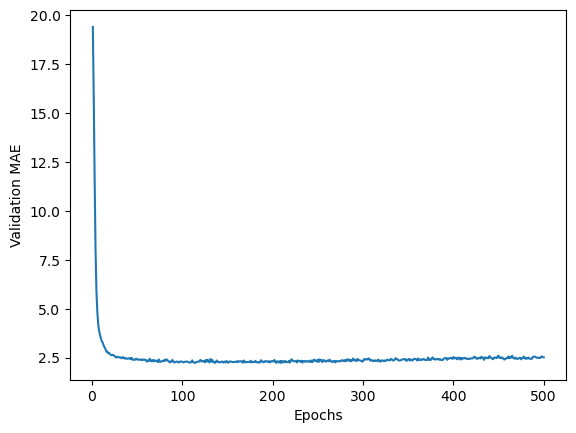

In [28]:
'''plotting validation scores'''

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

It may be a little difficult to read the plot, due to a scaling issue, The validation MAE for the first few epochs is dramatically higher than the values that follow. Let’s omit the first 10 data points, which are on a different scale than the rest of the curve.

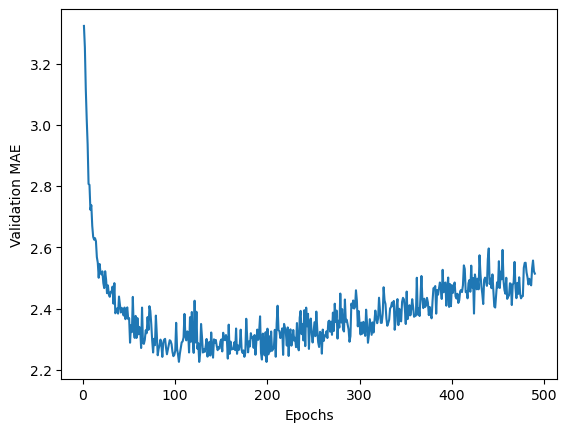

In [29]:
'''Plotting validation scores, excluding the first 10 data points'''
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

As you can see in the plot above, the validation MAE stops improving significantly after 120–140 epochs (this number includes the 10 epochs we omitted). Past that point, we start overfitting.

 Once you are done tuning other parameters of the model (in addition to the number of epochs, you could also adjust the size of the intermediate layers), you can train a final production model on all of the training data, with the best parameters,
and then look at its performance on the test data.

In [32]:
'''Training the final model'''

#Gets a fresh, compiled model
model = build_model()
model.fit(train_data, train_targets,
#Trains it on the entirety of the data
          epochs=120, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 14.8338 - mae: 2.5001


In [33]:
test_mae_score

2.500082015991211

We are still off by a bit under 2,500 dollars. It is an improvement! Just like with the two previous tasks, you can try varying the number of layers in the model, or the number of units per layer, to see if you can squeeze out a lower test error.

In [42]:
predictions = model.predict(test_data)
predictions.shape
predictions = (predictions*std) + mean
predictions.shape

4/4 [==============================] - 0s 857us/step


(102, 1)

*   Regression is done using different loss functions than we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.
*   Similarly, evaluation metrics to be used for regression differ from those used for classification. Naturally, the concept of accuracy does not apply for regression. A common regression metric is mean absolute error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
*   When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
*   When little training data is available, it is preferable to use a small model with few intermediate layers (typically only one or two), in order to avoid severe overfitting.